# Step 1: Import Libraries

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, Reshape, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
from textwrap import wrap

warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 12
sns.set_style("dark")


# Step 2: Load and Explore the Data

In [41]:
# Load dataset
data = pd.read_csv("flickr8k/captions.txt")
data

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [42]:
# number of images
data.image.nunique()

8091

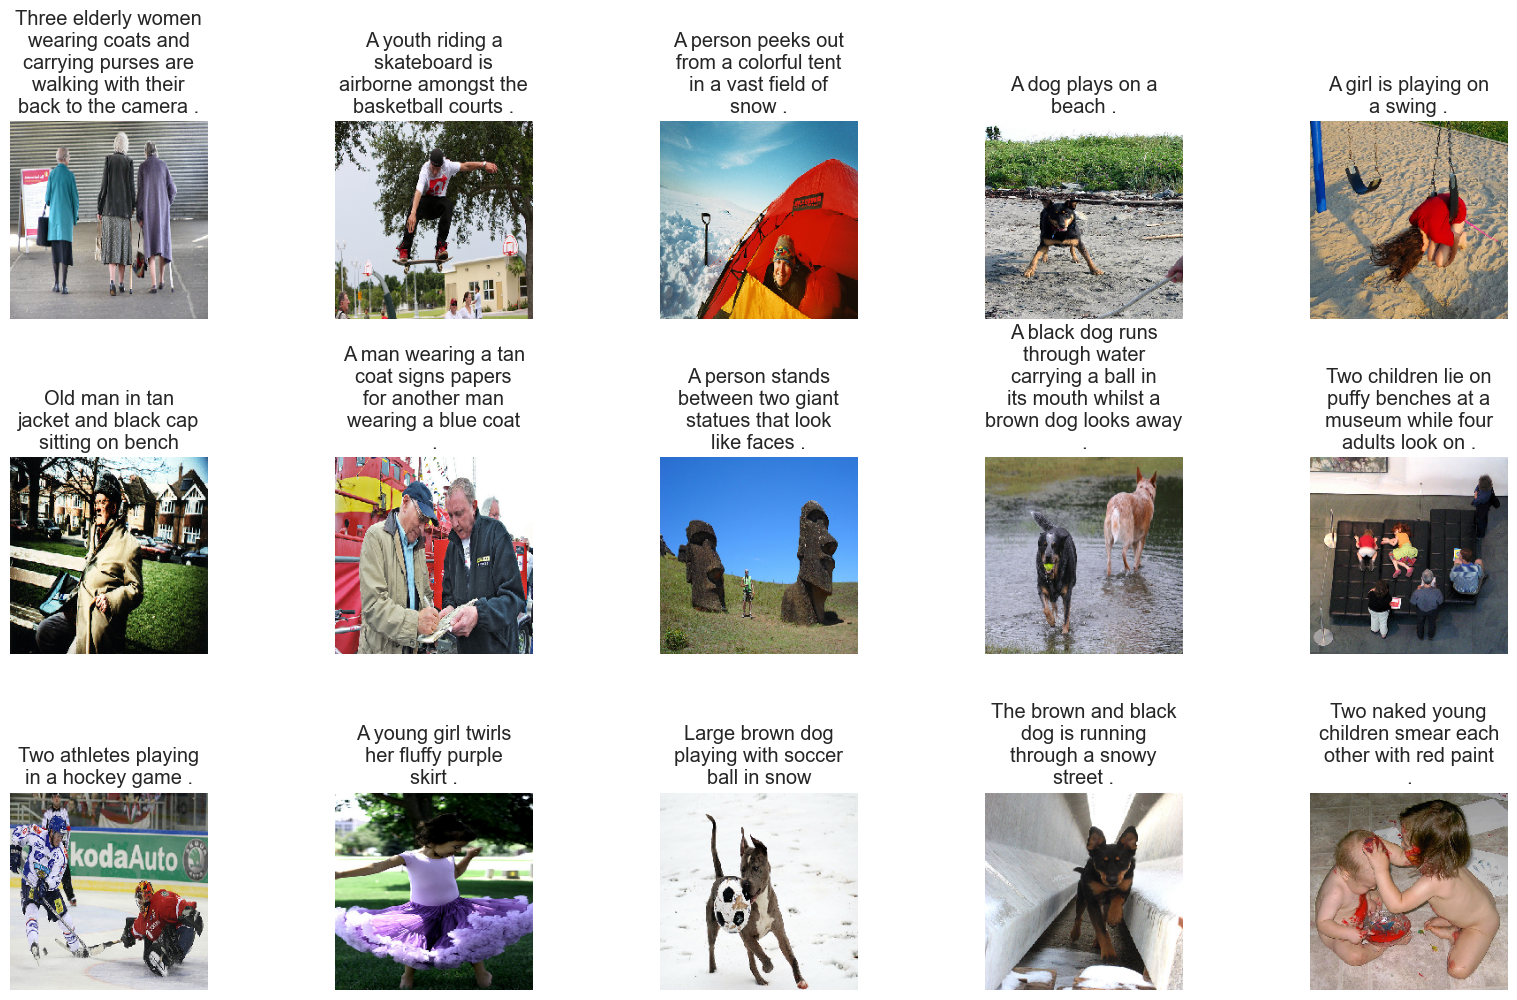

In [43]:
# Define a function to load and display images
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

# Step 3: Preprocessing Captions

In [44]:
import re

def text_preprocessing(data):
    data['caption'] = data['caption'].str.lower()
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    data['caption'] = data['caption'].apply(lambda x: "startseq " + x + " endseq")
    return data

data = text_preprocessing(data)
data

,image,caption
0,1000268201_693b08cb0e.jpg,startseq a child in a pink dress is climbing u...
1,1000268201_693b08cb0e.jpg,startseq a girl going into a wooden building e...
2,1000268201_693b08cb0e.jpg,startseq a little girl climbing into a wooden ...
3,1000268201_693b08cb0e.jpg,startseq a little girl climbing the stairs to ...
4,1000268201_693b08cb0e.jpg,startseq a little girl in a pink dress going i...
...,...,...
40450,997722733_0cb5439472.jpg,startseq a man in a pink shirt climbs a rock f...
40451,997722733_0cb5439472.jpg,startseq a man is rock climbing high in the ai...
40452,997722733_0cb5439472.jpg,startseq a person in a red shirt climbing up a...
40453,997722733_0cb5439472.jpg,startseq a rock climber in a red shirt endseq


# Step 4: Text Tokenization and Train-Test Split

In [45]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['caption'])

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in data['caption'])
print(vocab_size, max_length)

8781 37


In [46]:
from sklearn.model_selection import train_test_split


images = data['image'].unique().tolist()
nimages = len(images) 

# Train-validation-test split (0.8/0.1/0.1)
train_images, temp_images = train_test_split(images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

train = data[data['image'].isin(train_images)]
val = data[data['image'].isin(val_images)]
test = data[data['image'].isin(test_images)]

train.reset_index(inplace=True, drop=True)
val.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [47]:
print(train.shape)
print(val.shape)
print(test.shape)

(32360, 2)
(4045, 2)
(4050, 2)


# Step 5: Feature Extraction using Pre-trained model
* Load Feature Extraction Results from pickles file (No need to rerun)

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionV3

def extract_features(directory, dataset):
    # load inceptionV3 without fine-tuning 
    base_model = InceptionV3(weights="imagenet")
    # Remove the last classification layer 
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    
    # Print the final output shape of the model
    print("Output Shape:", model.output_shape)

    features = {}
    for image_name in images:
        filename = os.path.join(directory, image_name)
        image = load_img(filename, target_size=(299, 299))  # InceptionV3 size
        image = img_to_array(image)
        image = preprocess_input(image)  # Preprocessing for InceptionV3
        feature = model.predict(np.expand_dims(image, axis=0), verbose=0)
        features[image_name] = feature.flatten()
    return features

In [79]:
# image_path = "flickr8k/Images"
# features = extract_features(image_path, data)

Output Shape: (None, 2048)


In [49]:
# Use pickle to save the features so that we dont need to resun the results everytime
import pickle

# Save features to a file using pickle
# with open('features.pkl', 'wb') as f:
#     pickle.dump(features, f)

# Reload features from the saved file
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [50]:
# Verify the loaded features
len(features)

8091

# Step 6: Define the Captioning Model Structure

In [51]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Add, concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout

def create_captioning_model(vocab_size, max_length, lstm_units):

    # Image Processor: Feature extractions
    inputs1 = Input(shape=(2048,)) # The output shape of the pretrained extracted features
    fe1 = Dense(256, activation='relu')(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe2_dropout = Dropout(0.5)(fe2)  # Add dropout after the feature extraction

    # Sequence Processor: Text Embeddings
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = LSTM(lstm_units)(se1)
    se2_dropout = Dropout(0.5)(se2)  # Add dropout after the LSTM

    # Decoder model
    decoder1 = concatenate([fe2_dropout, se2_dropout])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    return model


In [25]:
# caption_model.output_shape

(None, 8781)

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(caption_model)

# Step 7: Function for Data Generation 

In [52]:
# Data generator for batch sized training 
def data_generator(data, tokenizer, max_length, vocab_size, features, batch_size):
    X1, X2, y = [], [], []
    while True:
        for index, row in data.iterrows():
            photo = features.get(row['image'], np.zeros((2048,)))
            seq = tokenizer.texts_to_sequences([row['caption']])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
                if len(X1) == batch_size:
                    yield [np.array(X1), np.array(X2)], np.array(y)
                    X1, X2, y = [], [], []

# Step 7: Functions for Model Evaluation

In [53]:
from nltk.translate.bleu_score import corpus_bleu

# Function to map an integer to a word
def int_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # Seed the generation process
    in_text = 'startseq'
    for i in range(max_length):
        # Convert the current description into a sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        yhat = model.predict([photo.reshape((1,2048)), sequence], verbose=0)
        # Convert the probability to an integer
        yhat = np.argmax(yhat)
        # Map integer to word
        word = int_to_word(yhat, tokenizer)
        # Stop if we cannot map the word or if endseq is reached
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    return in_text

# Function to evaluate the model
def evaluate_model(model, data, tokenizer, max_length, features):
    actual, predicted = [], []
    for index, row in data.iterrows():
        print(f"Processing {index+1}/{len(data)} rows")  # Print progress
        # Generate description
        yhat = generate_desc(model, tokenizer, features[row['image']], max_length)
        # Store actual and predicted
        actual.append([row['caption'].split()])
        predicted.append(yhat.split())
    
    return actual, predicted  

# Prepare the features as numpy arrays for prediction
for key in features.keys():
    features[key] = np.array(features[key]) 

# Step 8:HyperparameterTuning 

In [54]:
# Test different lstm units 
batch_size = 64
lstm_units = 512

# Create the model
caption_model = create_captioning_model(vocab_size, max_length, lstm_units)

# data generator 
train_generator = data_generator(data=train,batch_size=batch_size,tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# Training the base model
steps = len(data) // batch_size # batch size 
caption_model.fit(train_generator, epochs=10, steps_per_epoch=steps, verbose=1)

# Testing 
actual, predicted = evaluate_model(caption_model, test, tokenizer, max_length, features)

# Calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

Epoch 1/10
632/632 [==============================] - 360s 560ms/step - loss: 5.1770
Epoch 2/10
632/632 [==============================] - 437s 692ms/step - loss: 4.3580
Epoch 3/10
632/632 [==============================] - 441s 697ms/step - loss: 4.1457
Epoch 4/10
632/632 [==============================] - 447s 707ms/step - loss: 4.0559
Epoch 5/10
632/632 [==============================] - 445s 702ms/step - loss: 4.0953
Epoch 6/10
632/632 [==============================] - 445s 705ms/step - loss: 4.0411
Epoch 7/10
632/632 [==============================] - 445s 705ms/step - loss: 3.9064
Epoch 8/10
632/632 [==============================] - 431s 682ms/step - loss: 3.8821
Epoch 9/10
632/632 [==============================] - 419s 662ms/step - loss: 3.7504
Epoch 10/10
632/632 [==============================] - 426s 672ms/step - loss: 3.6871
Processing 1/4050 rows
Processing 2/4050 rows
Processing 3/4050 rows
Processing 4/4050 rows
Processing 5/4050 rows
Processing 6/4050 rows
Processing 

KeyboardInterrupt: 